---
### Master of Science in Signal Theory and Communications (MUTSC)
### *Signal processing and machine learning for big data*
## <font color=orange>ETSIT - UPM</font>
---
Author: Guerrero-López, Alejandro (2024)


# Introduction to Spiking Neural Networks (SNNs) using snntorch



<img title="SNN image gif" alt="SNN image gif" src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/spike_excite_alpha_ps2.gif?raw=true">


## Theoretical Background

Spiking Neural Networks (SNNs) are a generation of neural networks that more closely mimic the way biological brains work. 
Unlike traditional artificial neural networks where the neuron's output is a continuous value, in SNNs, 
neurons communicate by means of discrete events or 'spikes'. These spikes are generated when a neuron's membrane potential 
reaches a specific threshold. 

SNNs can process information in a temporal and sparse manner, which makes them energy efficient and suitable 
for processing time-dependent data.

## Setting up the Environment

Before diving into the practical aspects, let's set up our environment by installing `snntorch` and importing the necessary libraries.

```bash


In [78]:
!pip install snntorch

# Encoding the dataset into an SNN-friendly format

In this tutorial, we will use the MNIST dataset to demonstrate how to encode the data into a format that can be used by SNNs. 

Rate encoding is a method used in Spiking Neural Networks (SNNs) to represent information by the frequency of spikes over a period of time. In this context, the intensity of a stimulus is encoded by the rate at which neurons fire spikes. Higher firing rates correspond to higher intensity values and vice versa.


## Example: Representing a '7' from the MNIST Dataset

The MNIST dataset consists of grayscale images of handwritten digits (0-9), each of size 28x28 pixels. Each pixel in these images can take a value from 0 (black) to 255 (white), representing the intensity of white at that pixel.

1. Repeatedly pass the same training sample $\mathbf{X}\in\mathbb{R}^{m\times n}$ to the network at each time step. This is like converting MNIST into a static, unchanging video. Each element of $\mathbf{X}$ can take a high precision value normalized between 0 and 1: $X_{ij}\in [0, 1]$. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_1_static.png?raw=true' width="700">
</center>

2. Convert the input into a spike train of sequence length `num_steps`, where each feature/pixel takes on a discrete value $X_{i,j} \in \{0, 1\}$.
In this case, MNIST is converted into a time-varying sequence of spikes that features a relation to the original image.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true' width="700">
</center>

The first method is quite straightforward, and does not fully exploit the temporal dynamics of SNNs. So let’s consider data-to-spike conversion (encoding) from (2) in more detail.

The module `snntorch.spikegen` (i.e., spike generation) contains a series of functions that simplify the conversion of data into spikes. There are currently three options available for spike encoding in `snntorch`:

1. Rate coding: [`spikegen.rate`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.rate)
2. Latency coding: [`spikegen.latency`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.latency)
3. Delta modulation: [`spikegen.delta`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.delta)

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true' width="1000">
</center>


### Applying Rate Encoding


In rate encoding, we convert these intensity values into spike rates. For instance, a pixel with a higher intensity value for white will cause the corresponding neuron to fire more rapidly. Conversely, a darker pixel with a lower intensity value will result in a lower firing rate.

1. **Normalization**: The pixel values are first normalized to a range suitable for the SNN, typically between 0 and 1. This normalization helps in mapping the pixel intensity to a spike rate effectively.

2. **Conversion to Spike Rates**: The normalized values are then used to determine the spike rates. For example, if we consider a time window of 100 ms for our SNN simulation, a fully white pixel (after normalization) might be set to fire 100 spikes per second, while a fully black pixel would fire 0 spikes per second.

3. **Generating Spikes**: Based on the spike rates, we generate spikes at each time step for the duration of the simulation. A neuron representing a pixel will fire spikes at intervals inversely proportional to the pixel's intensity.





### Use MNIST as an Example

Let's start by performing the normalization, conversion to spike rates, and generation of spikes for a single digit '7' from the MNIST dataset. After that, we'll use spikegen.rate to encode the full dataset.

First, we need to load the MNIST dataset and select a '7' to work with:

In [79]:
!pip install torchvision

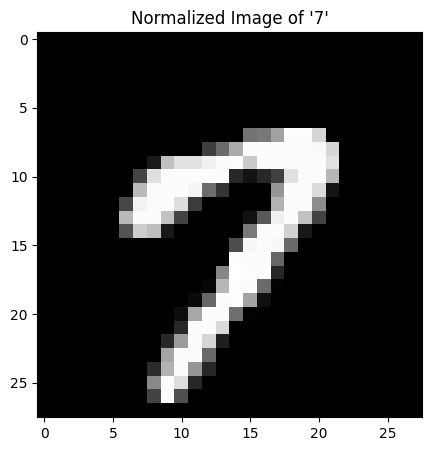

In [80]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import snntorch.spikegen as spikegen

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
mnist_train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test_full = datasets.MNIST(root="./data", train=False, download=True, transform=transform)


mnist_train = torch.utils.data.Subset(mnist_train_full, range(5000))
mnist_test = torch.utils.data.Subset(mnist_test_full, range(1000))


# Filter out data to get an example of '7'
sevens = [img for img, label in mnist_train if label == 7]

# Select a single '7' to work with
img_seven = sevens[0][0]

# Normalization (MNIST is already normalized, but this is for demonstration)
img_seven_normalized = img_seven / img_seven.max()

# Plot the normalized image
plt.figure(figsize=(5, 5))
plt.imshow(img_seven_normalized.squeeze(), cmap='gray')
plt.title("Normalized Image of '7'")
plt.show()


## Convert to Spike Rates

Now that we have the normalized pixel values, we can convert them into spike rates. We'll use the `snntorch.spikegen.rate` function to do this. This function takes in the normalized pixel values and the duration of the simulation in milliseconds.

Let's convert the normalized pixel values into spike rates for the digit '7' we selected earlier:

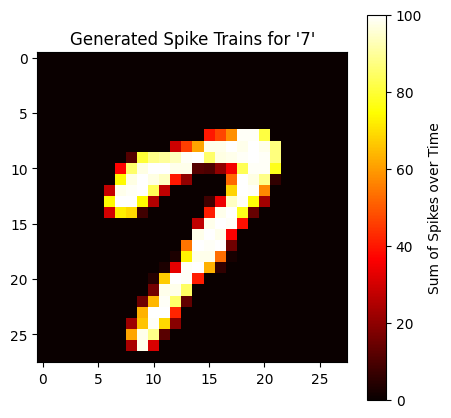

In [81]:
import snntorch.spikegen as spikegen

spike_rates = img_seven_normalized
time_window = 100  # time steps
spike_trains = spikegen.rate(spike_rates, num_steps=time_window)

# Summing spikes over time to visualize
spike_sum = spike_trains.sum(0).squeeze()

# Plot the generated spikes
plt.figure(figsize=(5, 5))
plt.imshow(spike_sum, cmap='hot')
plt.colorbar(label='Sum of Spikes over Time')
plt.title("Generated Spike Trains for '7'")
plt.show()

### Now the full dataset

Reducing the time window to 25 steps makes the spike generation process more computationally efficient. Let's encode the full MNIST dataset using this new setting and then create a video animation for a few random images.

First, we need to encode the full dataset with a time window of 100 steps:

In [82]:
loader = torch.utils.data.DataLoader(mnist_train, batch_size=1, shuffle=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=True, drop_last=True)

time_window = 25  # time steps
encoded_dataset = []

for img, label in loader:
    img_normalized = img / img.max()  # Normalizing
    spike_rates = img_normalized 
    spike_trains = spikegen.rate(spike_rates, num_steps=time_window)
    encoded_dataset.append((spike_trains, label))

Now, let's create an animation of the spike trains for 2-3 random images from the encoded dataset:

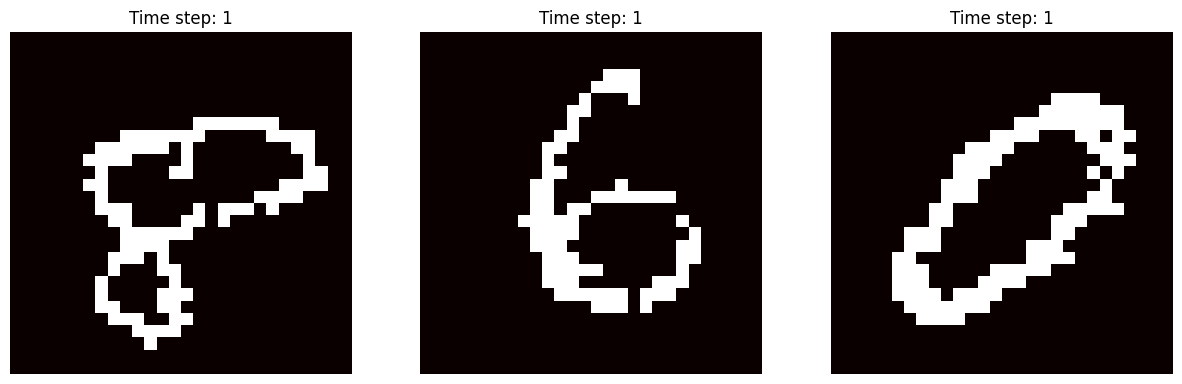

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Select 2-3 random images from the encoded dataset
samples = np.random.choice(len(encoded_dataset), 3, replace=False)
sample_images = [encoded_dataset[i][0] for i in samples]  # only get the spike trains

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Creating animation
def animate(i):
    for idx, ax in enumerate(axs):
        ax.clear()
        spike_train = sample_images[idx]
        img = spike_train[i].squeeze()
        ax.imshow(img, cmap='hot')
        ax.set_title(f"Time step: {i+1}")
        ax.axis('off')

ani = animation.FuncAnimation(fig, animate, frames=time_window, interval=50)
HTML(ani.to_html5_video())



# Network Architecture

Now that we have encoded the MNIST dataset into a format suitable for SNNs, we can move on to defining the network architecture. In this tutorial, we will implement a simple MLP with LIF neurons and surrogate gradients.

To define a simple Multi-Layer Perceptron (MLP) with Leaky Integrate-and-Fire (LIF) neurons and use a surrogate gradient for training in a Spiking Neural Network (SNN), we'll follow these steps:

## Define the Network Architecture:
We'll create an MLP with one hidden layer. Each layer will consist of LIF neurons.

We'll use snntorch to define LIF neurons. The snntorch library integrates with PyTorch, making it easier to create SNNs with familiar PyTorch syntax.



In [84]:
import snntorch as snn
from snntorch import spikegen
import torch
from torch import nn
import torch.nn.functional as F
from snntorch import surrogate
from snntorch import utils



class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        # Initialize layers
        spike_grad = surrogate.fast_sigmoid(slope=25)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=0.99, # Decay factor Beta
                            threshold=1, # U_{thr} threshold to generate a spike
                            learn_beta=False, # We don't want to learn the decay factor, just a hyperparameter
                            reset_mechanism='subtract', # We will substract the threshold voltage when a spike is generated (-R*U_{thr})
                            spike_grad=spike_grad)  # We will use a fast sigmoid as a surrogate gradient
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = snn.Leaky(beta=0.99, threshold=1, learn_beta=False, reset_mechanism='subtract', spike_grad=spike_grad,
                              output=True) # We want to get the output of the LIF neuron which is the membrane potential 

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x, mem1 = self.lif1(x, mem1) #
        x = self.fc2(x)
        x, mem2 = self.lif2(x, mem2)
        return x, mem2


### Leaky Integrate-and-Fire (LIF) Neuron Model
The Leaky Integrate-and-Fire (LIF) neuron is a simplified model of a biological neuron used in spiking neural networks (SNNs). It captures the essential characteristics of a neuron's electrical activity, including the integration of incoming signals and the generation of spikes when a certain threshold is reached.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_spiking.png?raw=true' width="450">
</center>

#### Membrane Potential Decay

The membrane potential, often denoted as `U`, represents the electrical charge across the neuron's membrane. In the LIF model, the membrane potential increases as it receives incoming spikes, simulating the integration of presynaptic inputs.

However, unlike a simple integrator, the LIF neuron has a "leaky" membrane, meaning the potential decays exponentially over time towards a resting value. Here, the resting value is set as "substracting" where basically it substracts the current threshold. This decay is governed by a parameter often denoted as `beta` or the decay factor. The equation for the membrane potential `U` at time `t` is given by:

$$ U(t) = U(t-1) * beta + I_{in}(t) - R*U_{thr} $$

where `I_{in}(t)` is basically the input (X) multiplied by the weights (W), `R` is the just and indicator function (1 or 0), and `U_{thr}` is the threshold where here is defined to 1. When a spike is generated, `U_{thr}` is substracted.

The decay factor `beta` ranges between 0 and 1. A value close to 1 means the membrane potential decays slowly, retaining more of its charge over time, while a value close to 0 leads to a rapid decay of the potential.

#### Threshold 
The threshold is a critical value of the membrane potential at which the neuron fires a spike. Once the membrane potential reaches this threshold, the neuron emits a spike and usually, the membrane potential is reset to its resting value, simulating the refractory period of a biological neuron.

#### Firing Mechanism

The firing mechanism of the LIF neuron is straightforward:

1. Integrate the incoming spikes to increase the membrane potential.
2. Allow the membrane potential to decay over time.
3. Check if the membrane potential has reached the firing threshold.
4. If the threshold is reached, emit a spike and reset the membrane potential.

This cycle repeats for each time step of the simulation, allowing the LIF neuron to generate spike trains in response to its input signals.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_5_reset.png?raw=true' width="450">
</center>


## Implement Surrogate Gradient:
Surrogate gradients are used to circumvent the non-differentiability of spike functions, enabling gradient-based optimization.

One of the most common surrogate functions is the fast sigmoid proposed in  Spike: Supervised Learning in Multilayer Spiking Neural Networks. Neural Computation, pp. 1514-1541. for the LIF neuron model. This surrogate gradient is a smoothed version of the non-differentiable spike function, allowing backpropagation through the network.

The sigmoidal functions must also be shifted such that they are centered at the threshold $U_{\rm thr}$. Defining  the overdrive of the membrane potential as $U_{OD} = U - U_{\rm thr}$:

$$\tilde{S} = \frac{U_{OD}}{1+k|U_{OD}|} \tag{3}$$
$$\frac{\partial \tilde{S}}{\partial U} = \frac{1}{(k|U_{OD}|+1)^2}\tag{4}$$

where $k$ modulates how smooth the surrogate function is, and is treated as a hyperparameter. As $k$ increases, the approximation converges towards the original derivative in $(2)$:  

$$\frac{\partial \tilde{S}}{\partial U} \Bigg|_{k \rightarrow \infty} = \delta(U-U_{\rm thr})$$ 


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial6/surrogate.png?raw=true' width="800">
</center>




## Training the Network:
We will train this network on a simple dataset (like MNIST) to demonstrate functionality.

In [85]:
epochs = 10


In [87]:
import torch
import torch.nn.functional as F
from snntorch import spikegen
from snntorch.functional import ce_rate_loss
from snntorch.functional import accuracy_rate
from tqdm import tqdm

# Assume we have a DataLoader `dataloader` for our dataset
model = SimpleMLP(input_size=28*28, hidden_size=100, output_size=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = ce_rate_loss()

epochs = 5  # Define the number of epochs


for epoch in range(epochs):
    acc = 0
    total = 0
    total_loss = 0
    
    for data, targets in tqdm(train_loader):
        optimizer.zero_grad()
        
        # Convert data to spike trains
        spike_data = spikegen.rate(data, num_steps=25)
        
        # Forward pass
        spk, mem = model(spike_data)

        # Compute loss
        loss = loss_fn(spk.unsqueeze(1), targets)
        total_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Compute accuracy using SF accuracy rate
        acc += accuracy_rate(spk.unsqueeze(1), targets) * targets.size(0)
        total += targets.size(0)
    
    accuracy = acc / total * 100
    avg_loss = total_loss / len(loader) 

    acc_test = 0
    total_test = 0
    
    for data, targets in tqdm(test_loader):
        spike_data = spikegen.rate(data, num_steps=25)
        spk, mem = model(spike_data)
        acc_test += accuracy_rate(spk.unsqueeze(1), targets) * targets.size(0)
        total_test += targets.size(0)
    
   
    
    print(f"Epoch {epoch+1}, CE Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Test Accuracy: {acc_test / total_test * 100:.2f}%")


100%|██████████| 1000/1000 [00:00<00:00, 1282.56it/s]


Epoch 1, CE Loss: 1.6640, Accuracy: 78.98%
Test Accuracy: 85.00%


100%|██████████| 1000/1000 [00:00<00:00, 1288.08it/s]


Epoch 2, CE Loss: 1.5622, Accuracy: 90.14%
Test Accuracy: 87.40%


100%|██████████| 1000/1000 [00:00<00:00, 1242.27it/s]


Epoch 3, CE Loss: 1.5440, Accuracy: 92.08%
Test Accuracy: 86.90%


100%|██████████| 1000/1000 [00:00<00:00, 1275.19it/s]


Epoch 4, CE Loss: 1.5299, Accuracy: 93.66%
Test Accuracy: 91.10%


100%|██████████| 1000/1000 [00:00<00:00, 1279.08it/s]

Epoch 5, CE Loss: 1.5242, Accuracy: 94.58%
Test Accuracy: 90.60%


## Visualization:
We'll plot some examples of the network's output.

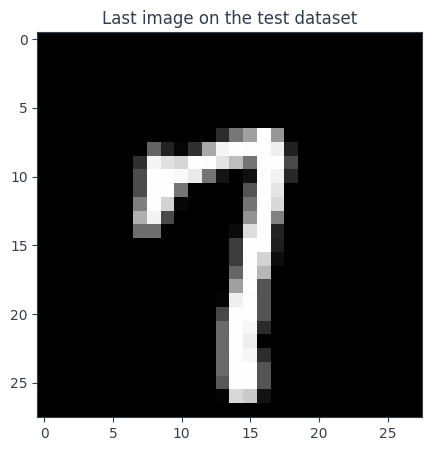

In [94]:
#plot the last image of test as example
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(data.squeeze(), cmap='gray')
plt.title("Last image on the test dataset")
plt.show()


The target label is: 7


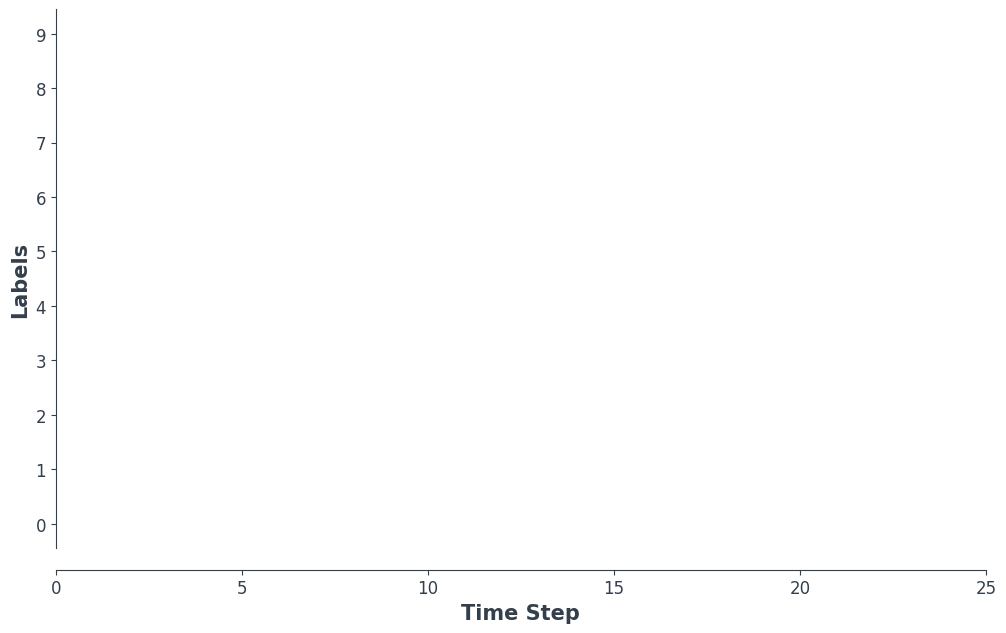

In [92]:
from IPython.display import HTML
from snntorch import spikeplot as splt

idx = 0

spk_rec = spk.detach().cpu()
fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec.detach().cpu(), fig, ax, labels=labels, 
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

# EXTRA Exercise: Transitioning from MLP to CNN

In this exercise, we challenge you to modify the existing Spiking Neural Network (SNN) model, transitioning from a Multi-Layer Perceptron (MLP) to a Convolutional Neural Network (CNN). Your task is to observe and quantify the improvement in accuracy that this change can bring.

## Task Description

1. **Implement a CNN SNN Model:**
   Convert the current `SimpleMLP` class into a CNN model. This involves replacing fully connected layers with convolutional layers and adding pooling layers if necessary. You can still use Leaky integrate-and-fire (LIF) neurons as the spiking mechanism in your convolutional layers.

2. **Train the CNN SNN Model:**
   Use the same MNIST dataset, but now with the CNN SNN model. Ensure you preprocess the input data correctly to fit the convolutional layers (keeping the image dimensions instead of flattening them).

3. **Compare the Performances:**
   After training the CNN SNN model, compare its performance against the original MLP SNN model. Focus on metrics like accuracy and note any significant changes or observations.

## Guidelines for Implementation

- **Convolutional Layer:** Start with a simple architecture, such as one or two convolutional layers followed by a fully connected layer for classification. Use `nn.Conv2d` for convolutional layers in PyTorch.
  
- **Pooling Layer:** Incorporate pooling layers (`nn.MaxPool2d`) to reduce the spatial size of the representation, which reduces the number of parameters and computation in the network.
  
- **Spike Function:** Apply the LIF neuron model as the activation function. You might need to adjust parameters like `beta` or `threshold` to optimize performance.

- **Output Layer:** The final layer should still be a fully connected layer that matches the number of classes in the MNIST dataset (10 classes from 0 to 9).

## Expected Outcome

The transition from MLP to CNN should ideally result in higher accuracy due to the CNN's ability to better capture spatial hierarchies in image data. The extent of accuracy improvement will depend on the specific architecture and parameters of your CNN SNN model.

Good luck!
